In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/content/drive/MyDrive/DATA/Frozen_Dessert_Production.csv")

In [14]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [19]:
df.columns = ['Production']

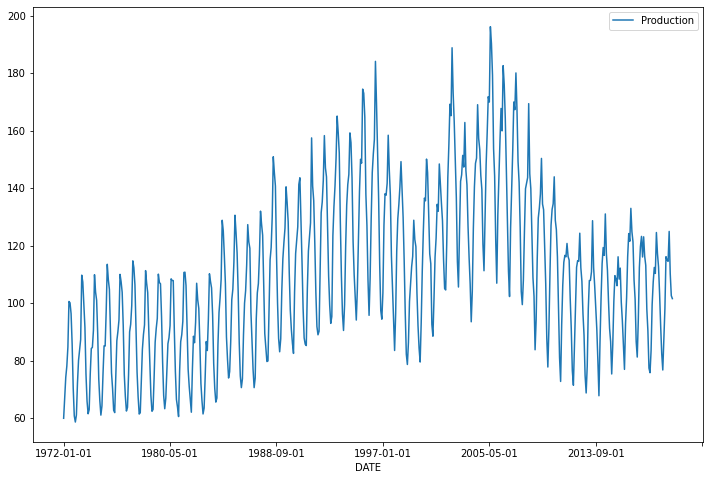

In [20]:
df.plot(figsize=(12,8))

Train Test Split

In [21]:
test_size = 24
test_ind = len(df) - test_size
train = df.iloc[:test_ind]
test= df.iloc[test_ind:]

Scale data

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

Time Series Generator

In [24]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [25]:
length = 18
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

Create a Model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [29]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

Create Early stopping

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

Fit the model to the generator

In [32]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/20
531/531 [==============================] - 10s 14ms/step - loss: 0.0259 - val_loss: 0.0066
Epoch 2/20
531/531 [==============================] - 8s 14ms/step - loss: 0.0090 - val_loss: 0.0062
Epoch 3/20
531/531 [==============================] - 7s 13ms/step - loss: 0.0051 - val_loss: 0.0019
Epoch 4/20
531/531 [==============================] - 7s 13ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 5/20
531/531 [==============================] - 7s 14ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 6/20
531/531 [==============================] - 7s 13ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 7/20
531/531 [==============================] - 8s 15ms/step - loss: 0.0031 - val_loss: 0.0020


Evaluate on Test Data

In [34]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch=first_eval_batch.reshape((1,length,n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [35]:
true_predictions=scaler.inverse_transform(test_predictions)

In [36]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,89.091627
2017-11-01,77.4378,82.430663
2017-12-01,75.8118,84.585887
2018-01-01,83.4343,92.805575
2018-02-01,99.4899,100.195791
2018-03-01,107.3152,105.983001
2018-04-01,112.4309,110.306994
2018-05-01,110.3544,113.274291
2018-06-01,124.5841,113.681028


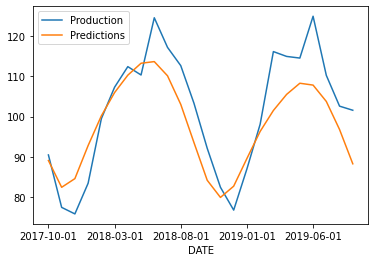

In [38]:
test.plot()

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

8.082078284488484